In [1]:
%load_ext autoreload
%autoreload 2

# standard
import sys
import os

# env specific
import numpy as np
import scipy.linalg as linalg
import cv2

import matplotlib.pyplot as plt
from matplotlib import rcParams

# custom
# sys.path.append('e:\\Dropbox\\py_projects\\signal\\signal')
# print(sys.path)
import src.signallib as sl


In [13]:
titlefont = 'Gill Sans MT'
mainfont = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [mainfont, titlefont]

rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Data Partition
---

The data for this analysis are the cropped images from [The Extended Yale Face Database B](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html).

The data is split into a train, validation, and test sets. In this dataset, there are multiple lighting conditions and poses for 38 human subjects. 

The train/valid/test sets all contain images from every subject. Which images of a given subject are randomized into the train/valid/test sets. 

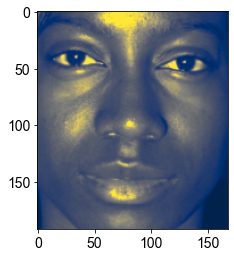

In [72]:
face = 'yaleB22'
image_filepath = f'E:/CroppedYale/{face}/'
image_filename = f'{face}_P00_Ambient.pgm'
image_filename = f'{face}_P00A+005E-10.pgm'

img_test = cv2.imread( image_filepath+image_filename, -1)

plt.imshow(img_test, cmap='cividis')

In [4]:
type(img_test[1,1])

numpy.uint8

In [6]:
image_filepath = f'E:/CroppedYale/'
# each folder contains images for one model
image_keys = [ s[-2:] for s in os.listdir(image_filepath) ]
# all folders have this prefix
image_key_filepath_prefix = 'yaleB'

# init RNG
rng = np.random.default_rng(seed=7)
# init train, valid, test file names lists
train_fns = {}
valid_fns = {}
test_fns = {}
# how many images in validation and test sets per model
nvalid_per_key = 2
ntest_per_key = 1

# create lists of filenames for each set
for k in image_keys:
   # fns in model folder
   fns = os.listdir(image_filepath+image_key_filepath_prefix+k)
   # ambient is sometimes not useful, discard non-PGM files
   fns = [fn for fn in fns if ('.pgm' in fn)
                              & ('Ambient' not in fn)
                              & ('.bad' not in fn)
                              ]
   
   nfns = len(fns)
   # shuffle the image names
   fns_permute = rng.choice(nfns, nfns, replace=False)

   # select image names for each data set
   train_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[:-(nvalid_per_key+ntest_per_key)]
               ]
   valid_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i
                  in fns_permute[-(nvalid_per_key+ntest_per_key):-ntest_per_key] 
               ]
   test_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[-ntest_per_key:]
               ]
    

## Load and Reshape Training Data
---

1. Load each image in the training set. 
2. Reshape the 2D images into a column vector. 
3. Subtract the average image of the training set from the image.

### Reduce input vector dimensions

Will the SVD classification scheme presented work when the dimensions of the input are less? What if they are on the order of the number of classes we are trying to distinguish between? Will there be enough information in the input to distinguish between classes/subjects?

Only a fraction of the pixels per input image are kept. It is helpful to no longer think of the data as coming from a 2D image, but just an N-dimensional vector of inputs (e.g. sensors on a car, power suppyly current readings for electromagnets in a partcile accelerator, etc.).

In [154]:
def load_img_vector( filepath, meanvec=None, smallerinput_pixels=None ):
    img = cv2.imread( filepath, flags=cv2.IMREAD_GRAYSCALE)
    imgvec = np.reshape(img, (-1, ))
    if smallerinput_pixels is not None:
        imgvec = imgvec[smallerinput_pixels]
    if meanvec is not None:
        imgvec = imgvec - meanvec
    return imgvec

# base path to images
image_filepath = f'E:/CroppedYale/'

# rows and columns of the images
NROWS = 192
NCOLS = 168
# number of training images
NTRAIN = sum([len(fns) for key,fns in train_fns.items()])

smallerinput = True
if smallerinput:
    # init RNG
    rng = np.random.default_rng(seed=42)
    # how many dimensions?
    N_XDIM = 10000
    # randomly select inputs
    pixels = rng.choice(NROWS*NCOLS, N_XDIM, replace=False)
else:
    N_XDIM = NROWS*NCOLS
    pixels = None

# init X matrix
train_X = np.zeros([N_XDIM, NTRAIN], dtype=np.uint8)
i = 0
for key, fns in train_fns.items():
    for fn in fns:
        imgvec = load_img_vector( image_filepath+fn, smallerinput_pixels=pixels )
        train_X[:,i] = imgvec
        i += 1

train_X_mean = train_X.mean(axis=1, keepdims=True)
train_meanvec = np.reshape(train_X_mean, (-1,)) # reshape
train_X_std = train_X.std(axis=1, keepdims=True)

train_X_meansub = (train_X - train_X_mean) 
train_X_norm = (train_X - train_X_mean) / train_X_std

## SVD
---

Perform SVD on the training set of images. 

In [155]:
# umat, svals, vmat = linalg.svd( train_X, full_matrices=False, check_finite=False)
umat, svals, vmat = linalg.svd( train_X_meansub, full_matrices=False, check_finite=False)
# umat, svals, vmat = linalg.svd( train_X_norm, full_matrices=False, check_finite=False)

Text(0.5, 1.0, 'Singular values of SVD on log-scale ')

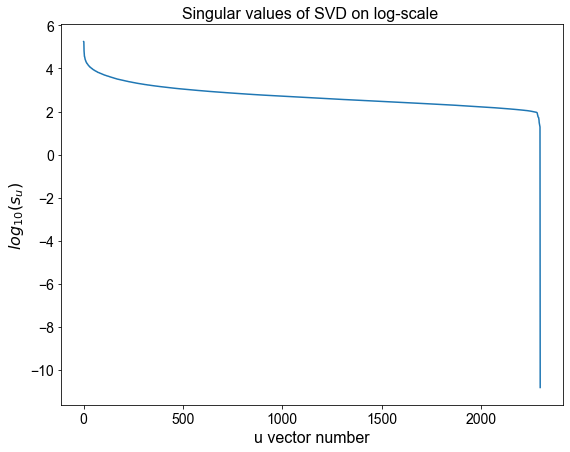

In [156]:
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(np.log10(svals))
ax.set_xlabel('u vector number')
ax.set_ylabel(r'$log_{10}( s_{u} )$')
ax.set_title('Singular values of SVD on log-scale ')


In [103]:
if not smallerinput:

    nu = 0
    img_uface = np.reshape(umat[:,nu], [NROWS, -1])
    img_meanface = np.reshape(train_X_mean, [NROWS, -1])
    fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(7,7))
    cmapname = 'cividis'
    ax0.imshow(img_uface, cmap=cmapname)
    ax1.imshow(img_meanface, cmap=cmapname)
    ax0.set_title(f'{nu}th u-face (eigenface) ')
    ax1.set_title(f'mean face')
    plt.show()

## Project onto u-space
---

1. For each subject, project their images onto the reduced vector space spanned by the first N columns of the U matrix.
2. Compute the average u-space projection for each subject.



In [157]:
# number of SVD vectors in dimension reduced U-space
N_UVEC = 100
umat_reduced = umat[:, :N_UVEC]

key_projections = {}

for key, fns in train_fns.items():
    # cols are projections of fn onto u-vectors
    uproj = np.zeros([ N_UVEC, len(fns)])

    for i,fn in enumerate(fns):
        imgvec = load_img_vector(image_filepath+fn, meanvec=train_meanvec, smallerinput_pixels=pixels)

        uproj_fn = (np.transpose(umat_reduced) @ imgvec) / svals[:N_UVEC]

        uproj[:,i] = uproj_fn
    
    key_projections[key] = uproj


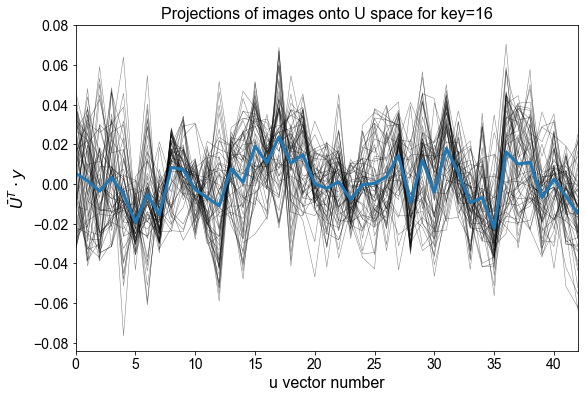

In [158]:
keytemp = '16'
fig,ax = plt.subplots(figsize=(9,6))
nimg = key_projections[keytemp].shape[1]

umean = np.mean(key_projections[keytemp], axis=1)
ax.plot((umean), linewidth=3, zorder=1)
for i in range(nimg):
    # ax.semilogy(np.abs(key_projections[keytemp][:,i]), color='k', linewidth=1.5, zorder=0)
    ax.plot((key_projections[keytemp][:,i]), color='k', linewidth=0.5, alpha=0.5, zorder=0)
ax.set_xlim([0,42])
# ax.set_ylim([-1000,1000])
ax.set_xlabel('u vector number', fontsize=16)
ax.set_ylabel(r'$\bar{U}^T \cdot y$', fontsize=16)
plt.title(f'Projections of images onto U space for key={keytemp}')
plt.show()

ValueError: operands could not be broadcast together with shapes (100,2300) (100,) 

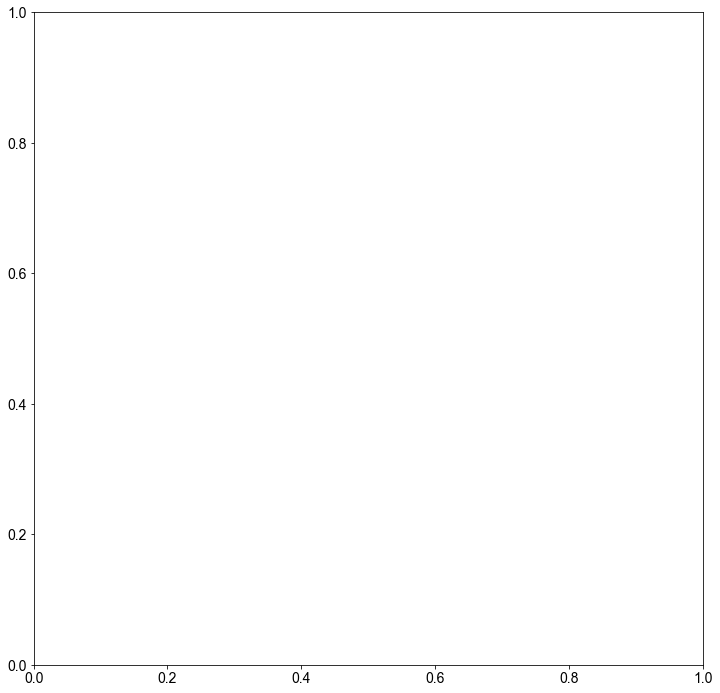

In [146]:
fig,ax = plt.subplots(figsize=(12,12))
train_projection = (np.transpose(umat_reduced) @ train_X_meansub) / svals[:N_UVEC]
# plt.imshow(train_projection[:22,:64], aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)
plt.imshow(train_projection[:22,4::64], aspect=1, cmap='coolwarm')

In [159]:
# average projection of key onto u-space
NKEYS = len(image_keys)
key_projections_u_mean = np.zeros([NKEYS, N_UVEC])
key_projections_u_median = np.zeros([NKEYS, N_UVEC])
for i,(key,proj) in enumerate(key_projections.items()):
    # print(i)
    key_projections_u_mean[i,:] = proj.mean(axis=1)
    key_projections_u_median[i,:] = np.median(proj, axis=1)

    

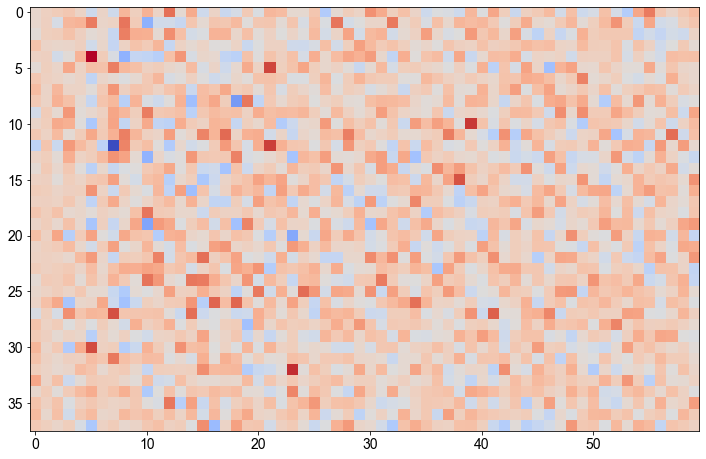

In [24]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean[:,:60] , aspect=1, cmap='coolwarm',  interpolation='none')

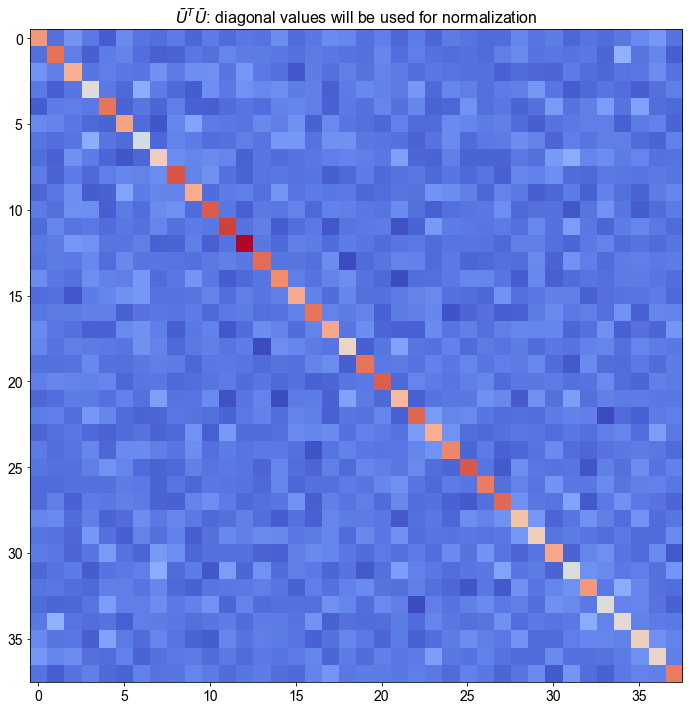

In [160]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean @ np.transpose(key_projections_u_mean) , aspect=1, cmap='coolwarm',  interpolation='none')

plt.title(r'$\bar{U}^T\bar{U}$: diagonal values will be used for normalization')
# plt.imshow(key_projections_u_median @ np.transpose(key_projections_u_median) , aspect=1, cmap='coolwarm',  interpolation='none')
# plt.imshow(np.transpose(key_projections_u_mean[:,:]), aspect=1, cmap='coolwarm', vmin=-5e3,vmax=5e3, interpolation='none')

plt.show()

## Classify Image
---

Attempt to classify an image (which subject is it?) based on its projection on the u-space. 
1. Load image, $\vec{y}$
2. Project onto reduced u-space, $U^T\vec{y}$
   1. Normalized by the singular values of the u vectors 
3. Matrix of average u-space projection, $V$
4. Compute correlation with subject classes: $V U^T\vec{y}$ 




In [161]:
def softmax( zvec ):
    """
    Boltzman distribution for the values of the zvec.
    """
    Z = np.sum(np.exp(zvec))
    return np.exp(zvec) / Z

def img_class_prob( imgvec, umat_reduced, key_project_mean, svals_reduced ):
    '''
    Project the image vector onto the reduced U space and compare to the average projection of the image classes.

    The projection is normalized by the 
    '''
    # normalize by singular value?
    imgvec_proj = (np.transpose(umat_reduced) @ imgvec) / svals_reduced
    normconst_imgvec_proj = np.sqrt(imgvec_proj @ imgvec_proj)
    normconstvec_key_proj = (key_project_mean @ np.transpose(key_project_mean)).diagonal()
    normconstvec_key_proj = np.sqrt(normconstvec_key_proj)
    # print(normconstvec_key_proj)
    imgvec_proj_overlap = (key_project_mean @ imgvec_proj)  / (normconstvec_key_proj * normconst_imgvec_proj)
    imgvec_proj_overlap = imgvec_proj_overlap
    # imgvec_probability = imgvec_proj_overlap
    imgvec_probability = softmax( imgvec_proj_overlap )
    return imgvec_probability



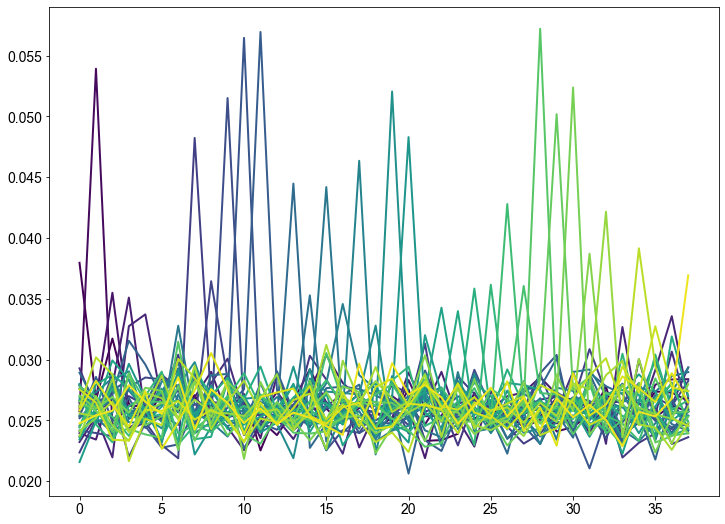

In [162]:
fig, ax = plt.subplots(figsize=(12,9))
from matplotlib import cm
cmap = cm.get_cmap('viridis')
image_keys_np = np.array(image_keys)
for i,keytemp in enumerate(image_keys[:]):
    fnindextemp = 7
    imgvec1 = load_img_vector(image_filepath+train_fns[keytemp][fnindextemp], meanvec=train_meanvec, smallerinput_pixels=pixels)
    img_prob = img_class_prob( imgvec1, umat_reduced, key_projections_u_mean, svals[:N_UVEC] )
    ls = {'linewidth':2.0, 'marker':'o', 'markersize':0}
    
    ls['color']=cmap((i)/NKEYS)
    ax.plot(np.arange(NKEYS),img_prob, **ls)
    # ax.step(np.arange(NKEYS),img_prob, **ls)

    # print(f'subject {keytemp}')
    # ipi = img_prob.argsort()
    # print(f'highest prob subjects {image_keys_np[ipi[-7:]]} ')
    # print(f'highest prob {100*img_prob[ipi[-7:]]} ')
    

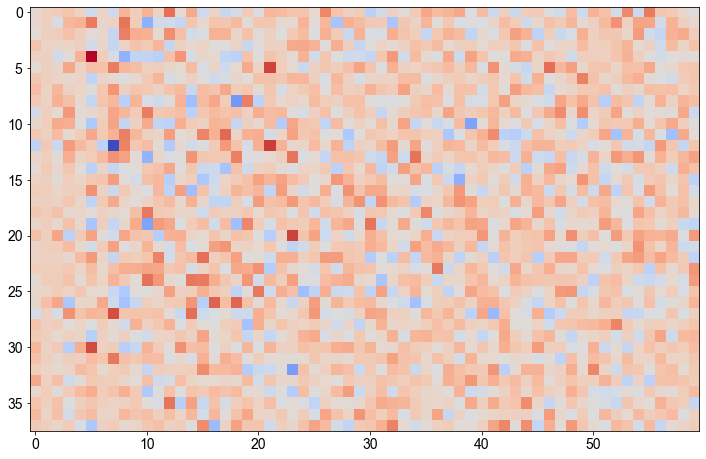

In [578]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean[:,:60] , aspect=1, cmap='coolwarm',  interpolation='none')

In [140]:
192*168

32256

## Classification Error
---

Compute the percentage of correctly classified images.

Increasing the size of the reduced U space improves the classification ability of this SVD based algorithm.

Number of pixels/input dimensions per image: 192*168 = 32256

| input dims | u-vecs      | error % |
| -----------| ----------- | --------|
| 32256      | 100         | 13.1    |
| 32256      | 500         | 3.95    |
| 32256      | 1000        | 1.32    |

Reducing the input dimensions increases the classification error. Although, once there are more inputs than u-space dimensions, the predictive error is the same as for the full input vector.

| input dims | u-vecs      | error % |
| -----------| ----------- | --------|
| 100        | 100         | 26.32   |
| 1000       | 100         | 13.16   |
| 10000      | 100         | 13.16   |


The success of this SVD classification approach relies on the tight constraints on the data. 
- The images are cropped and positioned in a well defined way. 
- There are many training data points for each class/subject. 
- There are only a few classes, $N_{classes}$, compared to the input information, $N_{pixels}$  
$$N_{classes} \ll N_{pixels} $$
  
These conditions lead to there being a large amount of information about the subject of the image in the vector space spanned by the columns of the reduced/truncated $U$ matrix.




In [163]:
def img_set_classification_error( fnsdict: dict, fnspath: str
                                , meanvec: np.ndarray
                                , umat_reduced: np.ndarray
                                , key_projections_u_mean: np.ndarray
                                , svals_reduced: np.ndarray
                                 ):
    keylist = list(fnsdict.keys())
    key_error_dict = {key:[] for key in keylist}
    key_probability_dict = {key:[] for key in keylist}

    key_predict_correct = 0
    total_fns = 0
    for i,(key,fns) in enumerate(fnsdict.items()):

        for fn in fns:
            total_fns += 1
            # compute class probability for each image file
            imgvec = load_img_vector( fnspath+fn, meanvec=meanvec, smallerinput_pixels=pixels )
            imgvec_prob = img_class_prob( imgvec, umat_reduced, key_projections_u_mean, svals_reduced )

            key_predict_probability = imgvec_prob.max()
            key_probability_dict[key].append(key_predict_probability)

            key_predict = keylist[imgvec_prob.argmax()]
            if key_predict == key:
                key_error_dict[key].append(0)
                key_predict_correct += 1
            else:
                key_error_dict[key].append(1)
            
    return key_predict_correct, total_fns, key_error_dict, key_probability_dict



In [164]:
valid_correct, valid_total, valid_key_error_dict, valid_key_probability_dict = img_set_classification_error( valid_fns, image_filepath
                              , train_meanvec
                              , umat_reduced, key_projections_u_mean, svals[:N_UVEC]
                                )

In [165]:
print(f'size of reduced u-space = {N_UVEC:d}')
print(f'correctly classified {(100*valid_correct / valid_total):0.2f}%')
print(f'classification error {100*(1 - valid_correct / valid_total):0.2f}%')

size of reduced u-space = 100
correctly classified 86.84%
classification error 13.16%


In [139]:
valid_key_error_dict

{'01': [0, 0],
 '02': [1, 1],
 '03': [0, 1],
 '04': [0, 1],
 '05': [1, 1],
 '06': [1, 0],
 '07': [0, 0],
 '08': [0, 0],
 '09': [0, 0],
 '10': [0, 0],
 '11': [0, 0],
 '12': [0, 0],
 '13': [0, 0],
 '15': [0, 0],
 '16': [0, 0],
 '17': [0, 1],
 '18': [1, 0],
 '19': [1, 0],
 '20': [1, 1],
 '21': [1, 1],
 '22': [0, 0],
 '23': [0, 0],
 '24': [0, 0],
 '25': [0, 0],
 '26': [0, 0],
 '27': [0, 1],
 '28': [0, 0],
 '29': [1, 0],
 '30': [0, 0],
 '31': [1, 0],
 '32': [0, 0],
 '33': [1, 0],
 '34': [0, 0],
 '35': [1, 0],
 '36': [1, 0],
 '37': [0, 0],
 '38': [0, 0],
 '39': [0, 0]}